<a href="https://colab.research.google.com/github/ParkEunHyeok/AI_Study/blob/main/NLP/Disaster_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 1.3 MB/s 
     |████████████████████████████████| 448 kB 16.0 MB/s 


In [173]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import urllib.request

from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from sklearn.model_selection import train_test_split

# LSTM learn
from sklearn import metrics
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Embedding, Dense, GRU, LSTM, Dropout, Bidirectional
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
import os
from google.colab import drive
drive.mount('/content/gdrive/')
path = "gdrive/My Drive/Colab Notebooks/Kaggle/disaster_tweet/"

Mounted at /content/gdrive/


In [105]:
train_data = pd.read_csv(path+'kaggle_data_translated.csv')
train_data = train_data.drop('Unnamed: 0', axis=1)
train_data.head()

,text,target
0,우리의 행동이 이 #지진의 이유이기를 알라하께서 우리 모두를 용서해 주시기를#지혜로...,1
1,라 롱지 사스크 근처에서 발생한 산불입니다. 캐나다애프터쇼크: David Wiede...,1
2,'피난처'를 요청받은 모든 주민들은 경찰관들로부터 통지를 받고 있다. 다른 대피소나...,1
3,"캘리포니아에서 13,000명의 사람들이 #산불 대피 명령을 받는다.Aftershoc...",1
4,이 사진은 루비 #알래스카에서 보내진 사진입니다. # 산불의 연기가 학교에 쏟아지고...,1


In [109]:
df = pd.read_csv(path+'tweet_data.csv', encoding='cp949', names=['text', 'target'])
df.head()

,text,target
0.0,RT @yang0067: 불한당 5주년 대관 후기 : 킹메이커 gv 대관 내자리는 ...,0.0
3.0,올해도 열대야는 네 덕에 잘 났다 이제 태풍 때문에 비 오고 바람 불 때 손 잡고 ...,0.0
4.0,RT @Maybe_Qz: 오늘도 단명미카가 너무 보고싶다.. 슈가 프랑스에서 작업하...,0.0
5.0,너무너무너무너무 스트레스 받음 따지고 보면 오늘이 마지막 날인데 재계약 결과는 안 ...,0.0
6.0,오늘도 단명미카가 너무 보고싶다.. 슈가 프랑스에서 작업하느라 핸드폰이 꺼진 줄도 ...,0.0


In [110]:
train_data = pd.concat([train_data, df])

In [111]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 1115 entries, 0.0 to nan
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   text    1093 non-null   object 
 1   target  1113 non-null   float64
dtypes: float64(1), object(1)
memory usage: 26.1+ KB


Text(0.5, 1.0, 'Target Distributions \n (0: Non Disaster, 1: Disaster)')

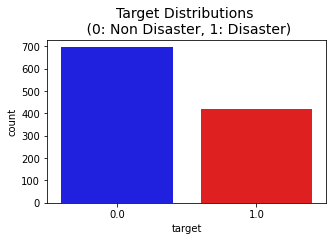

In [112]:
plt.figure(figsize=(5, 3))
colors = ["blue", "red"]

sns.countplot(x='target', data=train_data, palette=colors)
plt.title('Target Distributions \n (0: Non Disaster, 1: Disaster)', fontsize=14)

In [113]:
train_data['text'] = train_data['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['text'] = train_data['text'].str.replace('^ +', "")
train_data.drop_duplicates(subset=['text'], inplace=True)
train_data['text'].replace('', np.nan, inplace=True)
train_data = train_data.dropna(how = 'any')
train_data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,text,target
0.0,우리의 행동이 이 지진의 이유이기를 알라하께서 우리 모두를 용서해 주시기를지혜로운 ...,1.0
1.0,라 롱지 사스크 근처에서 발생한 산불입니다 캐나다애프터쇼크 의 다음 글로벌 금융 ...,1.0
2.0,피난처를 요청받은 모든 주민들은 경찰관들로부터 통지를 받고 있다 다른 대피소나 대피...,1.0
3.0,캘리포니아에서 명의 사람들이 산불 대피 명령을 받는다 완전 스트리밍,1.0
4.0,이 사진은 루비 알래스카에서 보내진 사진입니다 산불의 연기가 학교에 쏟아지고 있습...,1.0


In [114]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 999 entries, 0.0 to 1093.0
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   text    999 non-null    object 
 1   target  999 non-null    float64
dtypes: float64(1), object(1)
memory usage: 23.4+ KB


In [148]:
# konlpy okt 토큰화 (오래 걸림)
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
okt = Okt()

X = []
for sentence in train_data['text']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X.append(temp_X)

print(X[:3])

[['우리', '행동', '지진', '이유', '이기', '알라', '하', '께서', '우리', '모두', '용서', '주', '시기', '지혜', '로운', '결혼', '보너스', '여러분', '삶', '을', '정말로', '향상', '시키다', '수', '있다', '분간', '매일', '습관', '벌써', '몇', '개', '나', '해', '요'], ['라', '롱', '지', '사스', '크다', '근처', '에서', '발생', '산불', '이다', '캐나다', '애프터', '쇼크', '다음', '글로벌', '금융', '붕괴', '에서', '자신', '이익', '을', '보호'], ['피난처', '요청', '받다', '모든', '주민', '경찰관', '로부터', '통지', '받다', '있다', '다른', '대피소', '나', '대피', '령', '내려지다', '않다', '것', '예상', '되다', '무섭다', '롤러코스터', '타다', '때', '뒤', '있다', '남자', '피', '비리다', '나', '살인', '소리', '지르다', '때', '실버', '우드', '에프', '터', '쇼크']]


In [149]:
# 정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

threshold = 3
total_cnt = len(tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print(total_cnt)
print(threshold - 1, rare_cnt)
print((rare_cnt / total_cnt)*100)
print((rare_freq / total_freq)*100)

4625
2 3428
74.11891891891892
26.294277929155314


In [150]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)

print(X[:3])

단어 집합의 크기 : 1198
[[67, 647, 172, 834, 140, 532, 67, 153, 103, 835, 262, 648, 1, 364, 58, 24, 2, 836, 302, 837, 154, 60, 13, 155, 63], [156, 141, 74, 303, 3, 33, 365, 10, 533, 434, 142, 649, 435, 838, 3, 263, 839, 1, 436], [46, 81, 46, 2, 88, 840, 13, 23, 534, 841, 15, 4, 650, 9, 264, 94, 38, 437, 2, 77, 304, 13, 842, 157, 305, 38, 651, 843, 434]]


In [151]:
y = np.array(train_data['target'])

In [152]:
# 빈 샘플들을 제거
drop_train = [index for index, sentence in enumerate(X) if len(sentence) < 1]
X = np.delete(X, drop_train, axis=0)
y = np.delete(y, drop_train, axis=0)
print(len(X))
print(len(y))

990
990


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


최대 길이 : 38
평균 길이 : 12.022222222222222


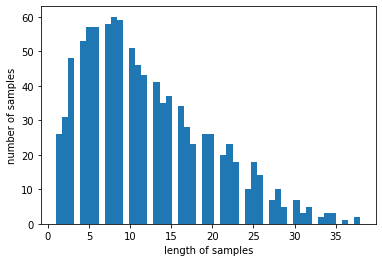

In [153]:
print('최대 길이 :',max(len(l) for l in X))
print('평균 길이 :',sum(map(len, X))/len(X))
plt.hist([len(s) for s in X], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [157]:
max_len = 40
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [174]:
# hyperparameter

embed_dim = 64
lstm_out = 64

In [177]:
model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(Dropout(0.2))
model.add(Bidirectional(GRU(lstm_out, dropout=0.2, recurrent_dropout=0.4)))
model.add(Dense(1,activation='sigmoid'))
adam = optimizers.Adam(learning_rate=0.002)

model.compile(loss = 'binary_crossentropy', optimizer=adam ,metrics = ['accuracy'])

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 64)          76672     
                                                                 
 dropout_1 (Dropout)         (None, None, 64)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 128)              49920     
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 126,721
Trainable params: 126,721
Non-trainable params: 0
_________________________________________________________________
None


In [178]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [179]:
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
11/11 [==============================] - 11s 389ms/step - loss: 0.6691 - accuracy: 0.6272 - val_loss: 0.6718 - val_accuracy: 0.6101
Epoch 2/15
11/11 [==============================] - 1s 130ms/step - loss: 0.6446 - accuracy: 0.6367 - val_loss: 0.6604 - val_accuracy: 0.6101
Epoch 3/15
11/11 [==============================] - 1s 130ms/step - loss: 0.5986 - accuracy: 0.6398 - val_loss: 0.6262 - val_accuracy: 0.6415
Epoch 4/15
11/11 [==============================] - 1s 132ms/step - loss: 0.4367 - accuracy: 0.8104 - val_loss: 0.6244 - val_accuracy: 0.6981
Epoch 5/15
11/11 [==============================] - 1s 131ms/step - loss: 0.2857 - accuracy: 0.9005 - val_loss: 0.7564 - val_accuracy: 0.7170
Epoch 6/15
11/11 [==============================] - 1s 130ms/step - loss: 0.2067 - accuracy: 0.9273 - val_loss: 0.8673 - val_accuracy: 0.6981
Epoch 7/15
11/11 [==============================] - 1s 131ms/step - loss: 0.1488 - accuracy: 0.9463 - val_loss: 1.0466 - val_accuracy: 0.6855
Epoch

In [180]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))
model.summary()

7/7 [==============================] - 0s 11ms/step - loss: 0.7826 - acc: 0.6818

 테스트 정확도: 0.6818
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 64)          76672     
                                                                 
 dropout_1 (Dropout)         (None, None, 64)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 128)              49920     
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 126,721
Trainable params: 126,721
Non-trainable params: 0
_________________________________________________________________


In [181]:
def tweet_predict(new_sentence):
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 재난 트윗입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 재난 트윗이 아닙니다.\n".format((1 - score) * 100))

In [182]:
tweet_predict('지진으로 인한 인명피해 발생')

66.02% 확률로 재난 트윗입니다.

